In [1]:
# all data sourced from https://www.kaggle.com/hm-land-registry/uk-housing-prices-paid
""" important note conveyancy takes 6-8 weeks - this means that from accepting offer to 
Date of Transfer could be two months different - this will be accounted for later in document"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
from sklearn.svm import SVR
import datetime

In [2]:
# Load data
housing_df = pd.read_csv('price_paid_records.csv')
# Display head of data
print(housing_df.head())

            Transaction unique identifier  Price  Date of Transfer  \
0  {81B82214-7FBC-4129-9F6B-4956B4A663AD}  25000  1995-08-18 00:00   
1  {8046EC72-1466-42D6-A753-4956BF7CD8A2}  42500  1995-08-09 00:00   
2  {278D581A-5BF3-4FCE-AF62-4956D87691E6}  45000  1995-06-30 00:00   
3  {1D861C06-A416-4865-973C-4956DB12CD12}  43150  1995-11-24 00:00   
4  {DD8645FD-A815-43A6-A7BA-4956E58F1874}  18899  1995-06-23 00:00   

  Property Type Old/New Duration   Town/City            District  \
0             T       N        F      OLDHAM              OLDHAM   
1             S       N        F       GRAYS            THURROCK   
2             T       N        F  HIGHBRIDGE           SEDGEMOOR   
3             T       N        F     BEDFORD  NORTH BEDFORDSHIRE   
4             S       N        F   WAKEFIELD               LEEDS   

               County PPDCategory Type Record Status - monthly file only  
0  GREATER MANCHESTER                A                                 A  
1            THURROC

In [3]:
#D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other 
def property_filter_out(data,col,filter_out=''):
    for item in filter_out:
        data = data[data[col]!=item]
    return data

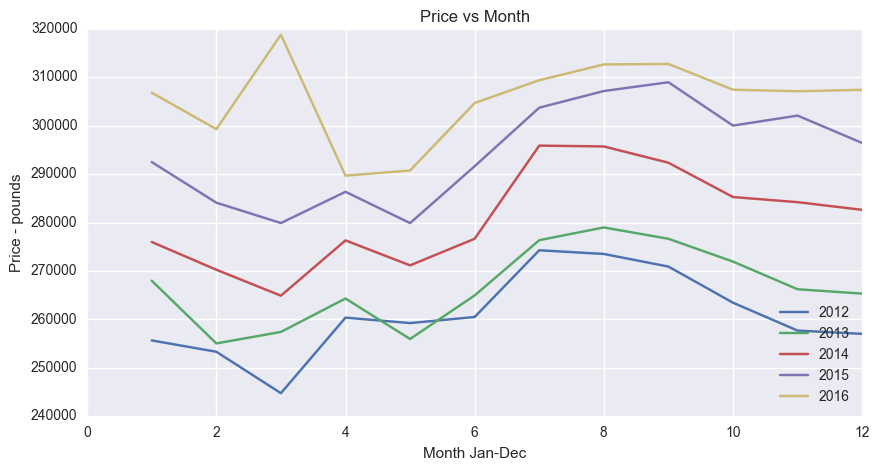

In [5]:
# filter out data we don't want 
housing_df = property_filter_out(housing_df,'Property Type','TFO')
# Convert the date column to actual datetime + create month/year columns
housing_df['Date of Transfer'] = pd.to_datetime(housing_df['Date of Transfer'],dayfirst=True)
housing_df['Est Date of Agreement'] = np.array(housing_df['Date of Transfer'])-np.timedelta64(8,'W')
housing_df['Year'] = housing_df['Date of Transfer'].dt.year
housing_df['Month'] = housing_df['Date of Transfer'].dt.month

# Create a pivot table of data and select only the last 10 years
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2012,2017)
housing_pivot = housing_pivot[time_range]
# Plot data
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.plot(housing_pivot)
plt.legend(time_range,loc=4)
plt.xlabel('Month Jan-Dec')
plt.ylabel("Price - pounds")
plt.title("Price vs Month")
plt.show()

# Result
The above graph appears to show a consistent dip during the beginning of the year and a rise later in the year.

This could potentially be a seasonal shift. Consider that the date used is date of transfer, so the agreed sale could be 2 months prior, which would put the dip around December/January. This could be due to colder weather.

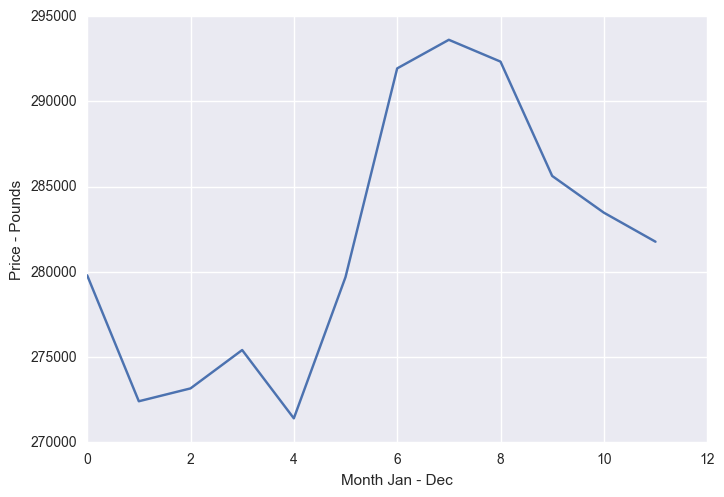

In [6]:
# Take the mean across years for each month - does price really vary by month?
avg_across_years = np.empty((12,1))

for i in range(0,12):
    avg_across_years[i,0] = np.mean(np.array(housing_pivot)[i,:])
plt.plot(avg_across_years)
plt.ylabel('Price - Pounds')
plt.xlabel('Month Jan - Dec')
plt.show()

# Result
This clearly shows that house price varies by time of year. The main dip is around April. 
Does this hold true in all cases? Is this different by region?
Could this difference relate to weather? 

Can we use:
https://www.metoffice.gov.uk/public/weather/climate-historic/#?tab=climateHistoric
Would this explain the variance from the best fit?

In [7]:
# All regions:
print(pd.unique(housing_df['County']))

['THURROCK' 'WEST YORKSHIRE' 'WILTSHIRE' 'OXFORDSHIRE' 'CORNWALL'
 'GREATER LONDON' 'LANCASHIRE' 'DERBYSHIRE' 'HAMPSHIRE' 'SOUTH YORKSHIRE'
 'MIDDLESBROUGH' 'THAMESDOWN' 'LINCOLNSHIRE' 'HERTFORDSHIRE'
 'WEST MIDLANDS' 'NORFOLK' 'HUMBERSIDE' 'GREATER MANCHESTER' 'AVON'
 'NOTTINGHAMSHIRE' 'WEST GLAMORGAN' 'MERSEYSIDE' 'HARTLEPOOL' 'SURREY'
 'TYNE AND WEAR' 'BLAENAU GWENT' 'SOUTHAMPTON' 'NORTHUMBERLAND'
 'EAST SUSSEX' 'WORCESTERSHIRE' 'CHESHIRE' 'ESSEX' 'NORTHAMPTONSHIRE'
 'LEICESTERSHIRE' 'SUFFOLK' 'POOLE' 'STOCKTON-ON-TEES' 'CUMBRIA'
 'SOMERSET' 'BRACKNELL FOREST' 'NORTH YORKSHIRE' 'CLWYD' 'SOUTHEND-ON-SEA'
 'WARWICKSHIRE' 'WARRINGTON' 'WEST SUSSEX' 'SHROPSHIRE' 'BERKSHIRE' 'KENT'
 'MID GLAMORGAN' 'HEREFORD AND WORCESTER' 'CONWY' 'NEWPORT'
 'CAMBRIDGESHIRE' 'WOKINGHAM' 'BUCKINGHAMSHIRE' 'TORBAY' 'BEDFORDSHIRE'
 'GWYNEDD' 'RUTLAND' 'GWENT' 'DARLINGTON' 'LEICESTER' 'DURHAM' 'DORSET'
 'DEVON' 'GLOUCESTERSHIRE' 'PEMBROKESHIRE' 'READING' 'STAFFORDSHIRE'
 'DYFED' 'POWYS' 'SOUTH GLOUCESTERSHIR

In [8]:
def best_fit(X,y):
    lr = linear_model.LinearRegression()
    X=X.reshape(len(X),1)
    y=y.reshape(len(y),1)
    lr.fit(X,y)
    return lr.predict(X)
def region_plot(county,year_start=2015,year_end=2017):
    # function to plot regio separately
    housing_pivot = pd.pivot_table(housing_df[housing_df['County']==county],values='Price',index='Month',columns='Year',aggfunc='mean')
    time_range = np.arange(year_start,year_end)
    housing_pivot = housing_pivot[time_range]
    X=np.array(housing_pivot.index)
    for year in time_range:
        y=housing_pivot[year]
        housing_pivot['{0}_BestFit'.format(year)]=best_fit(X,y)
    # Plot data
    plt.figure(figsize=(10,5))
    plt.subplot(1,1,1)
    plt.plot(housing_pivot)
    plt.legend(housing_pivot.columns,loc=4)
    plt.xlabel('Month Jan-Dec')
    plt.ylabel("Price - pounds")
    plt.title("Price vs Month")
    plt.show()
    return housing_pivot

# Temperature data
Data was sourced for the UK as a whole.

source: https://www.statista.com/statistics/322658/monthly-average-daily-temperatures-in-the-united-kingdom-uk/
(saved as file weatherAverage.xlsx)

In [10]:
uk_temp_df = pd.read_excel('weatherAverage.xlsx')

In [14]:
# Create pivot table of housing data by month & year
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2013,2017)
housing_pivot = housing_pivot[time_range]
print(housing_pivot)

Year            2013           2014           2015           2016
Month                                                            
1      268005.161945  275996.144230  292495.791675  306812.399235
2      255050.644734  270267.456484  284106.245751  299285.554082
3      257427.276566  264910.180133  279904.958446  318789.558252
4      264323.927295  276323.276140  286356.771504  289688.866732
5      255967.751911  271168.218055  279891.872982  290754.544746
6      264957.660354  276660.570082  291637.976657  304684.755594
7      276366.362852  295889.353413  303721.399694  309392.920409
8      278996.067473  295718.958578  307157.252348  312653.203663
9      276657.556044  292357.397839  308973.628422  312743.375449
10     271945.608222  285271.780895  300021.090892  307429.950846
11     266234.138561  284216.101908  302086.620013  307116.634064
12     265334.264804  282630.663759  296433.262010  307410.748104


In [15]:
# Create training data to test if temperature is relevant
first = True
for year in time_range:
    temp_arr = np.ones((12,5))
    if year==time_range[0]:
        time_arr = np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')
    else:
        time_arr = np.concatenate((time_arr,np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')),axis=0)
    temp_arr[:,0] = np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')
    # weather
    temp_arr[:,2] = np.array(uk_temp_df[str(year)])
    # weather squared
    temp_arr[:,3] = np.array(uk_temp_df[str(year)])**2
    # price
    temp_arr[:,4] = np.array(housing_pivot[year])
    if first == True:
        X = temp_arr[:,:4]
        y = temp_arr[:,4]
        first = False
    else:
        X = np.concatenate((X,temp_arr[:,:4]),axis=0)
        y = np.concatenate((y,temp_arr[:,4]),axis=0)
print('X and y constructed.')


X and y constructed.


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr_simple = linear_model.LinearRegression()
lr_simple.fit(X_train,y_train)
prediction = lr_simple.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
#print(confusion_matrix(prediction,y_test))
#print(classification_report(prediction,y_test))
print('R2 score: {0}'.format(lr_simple.score(X_test,y_test)))



R2 score: 0.7571392392773869
